In [1]:
import pandas as pd
import numpy as np
import ast
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def join_reviews(data, isPreprocessed=True):
    if (isPreprocessed):
        review_text = []
        reviews = (data['review'].apply(ast.literal_eval))
        review_strings = reviews.apply(' '.join)
        review_strings.apply(review_text.append)
    
    return review_text

def graph_word_cloud(data, isPreprocessed=True):
    if (isPreprocessed):
        review_lists = (data['review'].apply(ast.literal_eval))
        review_strings = review_lists.apply(' '.join)
        corpus = ' '.join(review_strings)
    else:
        corpus = data['review'].str.cat(sep=' ')
        
    word_cloud = WordCloud(width=1600, height=800, collocations=False).generate(corpus)
    plt.figure(figsize=(20,20))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
def stem_review(review):
    stemmer = PorterStemmer()
    stemmed_review = [stemmer.stem(token) for token in review]
    return stemmed_review
  
def stem_data(data):
    data_copy = data.copy()
    data_copy['review'] = data_copy['review'].apply(ast.literal_eval)
    data_copy['review'] = data_copy['review'].apply(stem_review)
    data_copy['review'] = data_copy['review'].apply(str)
    return data_copy

def get_frequencies(data, vocab):
    vocab_dict = {vocab[i]: i for i in range(len(vocab))}
    corpus = join_reviews(data)
    vectorizer = CountVectorizer(vocabulary=vocab)
    X = vectorizer.fit_transform(corpus)

    words = vectorizer.get_feature_names()
    word_frequencies = X.toarray().sum(axis=0)
    cv_results = dict(zip(words, word_frequencies))
    return cv_results

def get_tfidf_weights(data, vocab):  
    vocab_dict = {vocab[i]: i for i in range(len(vocab))}
    
    corpus = join_reviews(data)
    vectorizer = TfidfVectorizer(vocabulary=vocab)
    X = vectorizer.fit_transform(corpus)

    words = vectorizer.get_feature_names()
    inverse_document_frequency = vectorizer.idf_
    tf_idf_results = dict(zip(words, inverse_document_frequency))
    return tf_idf_results

def get_series(category, frequencies):
    frequency_series = pd.Series(data=frequencies, name='frequency')
    frequency_series.index.name = category
    frequency_series.reset_index()
    return frequency_series

In [3]:
data = pd.read_csv('data/review_data.csv')
preprocessed_data = pd.read_csv('data/preprocessed_review_data.csv')

In [4]:
# data exploration
print("Columns: {0}\n".format(preprocessed_data.columns.values))
print("Total reviews: {0}\n".format(preprocessed_data.shape[0]))
print("Was recommended:\n{0}".format(preprocessed_data['voted_up'].value_counts()))

Columns: ['steam_id' 'review' 'timestamp_created' 'voted_up']

Total reviews: 20000

Was recommended:
True     19014
False      986
Name: voted_up, dtype: int64


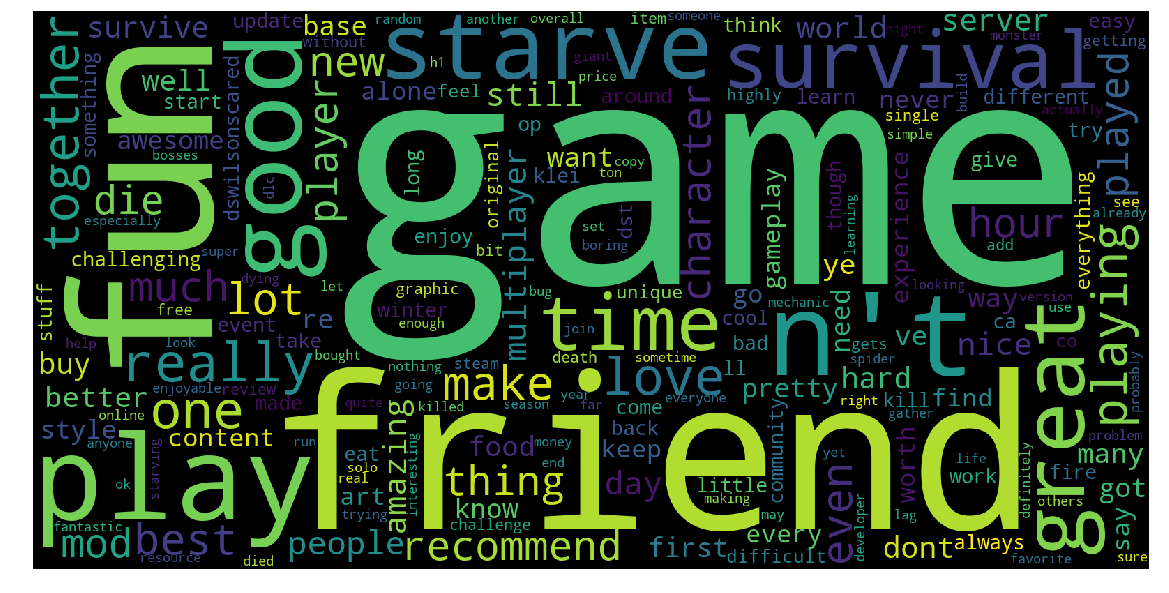

In [5]:
# wordcloud with preprocessing
graph_word_cloud(preprocessed_data)

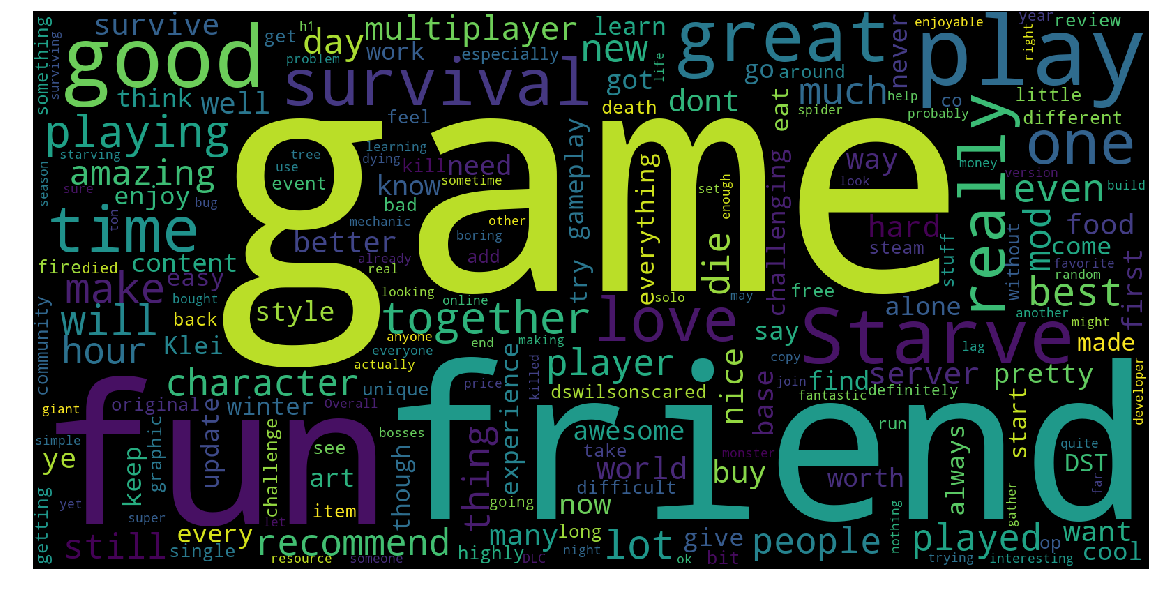

In [6]:
# wordcloud without preprocessing
graph_word_cloud(data, isPreprocessed=False)

In [7]:
characters = ["wilson", "willow", "wolfgang", "wendy", 
              "wx", "wickerbottom", "woodie", "wes", 
              "maxwell", "wigfrid", "webber", "warly", 
              "wormwood", "winona", "wortox", "wurt"]

character_frequencies = get_frequencies(preprocessed_data, characters)
character_weights = get_tfidf_weights(preprocessed_data, characters)

In [8]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [9]:
monsters = ["spiders", "hounds", "bees", "frogs", "pigs", "tentacles", "merms", "beargers", "deerclops", "dragonfly"]
lemmatized_monsters = [lemmatizer.lemmatize(monster) for monster in monsters]
stemmed_monsters = [stemmer.stem(monster) for monster in monsters]
print("lemmatized:", lemmatized_monsters)
print("stemmed:", stemmed_monsters)

stemmed_data = stem_data(preprocessed_data)

monster_frequencies = get_frequencies(stemmed_data, stemmed_monsters)
monster_weights = get_tfidf_weights(stemmed_data, stemmed_monsters)

lemmatized: ['spider', 'hound', 'bee', 'frog', 'pig', 'tentacle', 'merms', 'beargers', 'deerclops', 'dragonfly']
stemmed: ['spider', 'hound', 'bee', 'frog', 'pig', 'tentacl', 'merm', 'bearger', 'deerclop', 'dragonfli']


In [11]:
seasons = ["autumn", "winters", "springs", "summers"]
stemmed_seasons = [stemmer.stem(season) for season in seasons]

season_frequencies = get_frequencies(stemmed_data, stemmed_seasons)
season_weights = get_tfidf_weights(stemmed_data, stemmed_seasons)

NameError: name 'stemmd_data' is not defined

In [ ]:
character_series = get_series("character", character_frequencies)
monster_series = get_series("monster", monster_frequencies)
season_series = get_series("season", season_frequencies)

In [ ]:
fig, axes = plt.subplots(ncols=2, 
                         nrows=2, 
                         figsize=(12, 12), 
                         squeeze=False)

fig.subplots_adjust(hspace=0.40)
axes = axes.flatten()
for axis in axes:
    plt.setp(axis.get_xticklabels(), rotation=30, ha="right")
    
character_barplot = sns.barplot(x=character_series.index, y=character_series.values, ax=axes[0])
character_barplot.set(title="Character Frequency", xlabel= "Characters", ylabel="Frequency")

monster_barplot = sns.barplot(x=monster_series.index, y=monster_series.values, ax=axes[1])
monster_barplot.set(title="Monster Frequency", xlabel= "Monster", ylabel="Frequency")

season_barplot = sns.barplot(x=season_series.index, y=season_series.values, ax=axes[2])
season_barplot.set(title="Season Frequency", xlabel= "Season", ylabel="Frequency")
    
plt.show()

It is important to note that the aspect ratios are NOT equal and may result in bias, affecting comparisons between different categories.

In [ ]:
display(character_weights)
display(monster_weights)
display(season_weights)